In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import coint

In [2]:
# Simulate data for two correlated assets
np.random.seed(42)
n = 1000
asset1 = np.cumsum(np.random.normal(0, 1, n))
asset2 = asset1 + np.random.normal(0, 1, n)

In [3]:
# Create a DataFrame
df = pd.DataFrame({'Asset1': asset1, 'Asset2': asset2})

In [4]:
# Cointegration test
score, pvalue, _ = coint(df['Asset1'], df['Asset2'])
print(f"Cointegration test p-value: {pvalue:.4f}")
if pvalue > 0.05:
    print("Warning: The assets may not be suitable for pairs trading (p-value > 0.05).")

Cointegration test p-value: 0.0000


In [5]:
# Calculate the spread
df['Spread'] = df['Asset1'] - df['Asset2']

In [6]:
# Generate dynamic Z-Score using rolling window
window = 50
mean_spread = df['Spread'].rolling(window).mean()
std_spread = df['Spread'].rolling(window).std()
df['Z-Score'] = (df['Spread'] - mean_spread) / std_spread

In [7]:
# Trading signals based on dynamic Z-Score with upper/lower thresholds
upper_threshold = 2
lower_threshold = -2
df['Long'] = df['Z-Score'] < lower_threshold
df['Short'] = df['Z-Score'] > upper_threshold

In [8]:
# Implement stop-loss mechanism
df['Stop-Loss'] = np.abs(df['Z-Score']) > 3

In [9]:
# Portfolio management: Track positions and calculate returns
df['Position'] = 0
df['Position'] = np.where(df['Long'], 1, df['Position'])
df['Position'] = np.where(df['Short'], -1, df['Position'])

In [10]:
# Apply stop-loss (close positions)
df['Position'] = np.where(df['Stop-Loss'], 0, df['Position'])

In [11]:
# Calculate portfolio returns
transaction_cost = 0.001  # Example transaction cost per trade
df['Returns'] = df['Position'].shift(1) * (df['Asset1'].pct_change() - df['Asset2'].pct_change())
df['Returns'] -= transaction_cost * np.abs(df['Position'] - df['Position'].shift(1))

In [12]:
# Cumulative returns and portfolio value
df['Cumulative Returns'] = (1 + df['Returns']).cumprod() - 1

In [13]:
# Calculate the Sharpe ratio (assuming risk-free rate = 0)
sharpe_ratio = df['Returns'].mean() / df['Returns'].std() * np.sqrt(252)  # Annualized Sharpe ratio
print(f"Sharpe Ratio: {sharpe_ratio:.4f}")

Sharpe Ratio: -0.0830


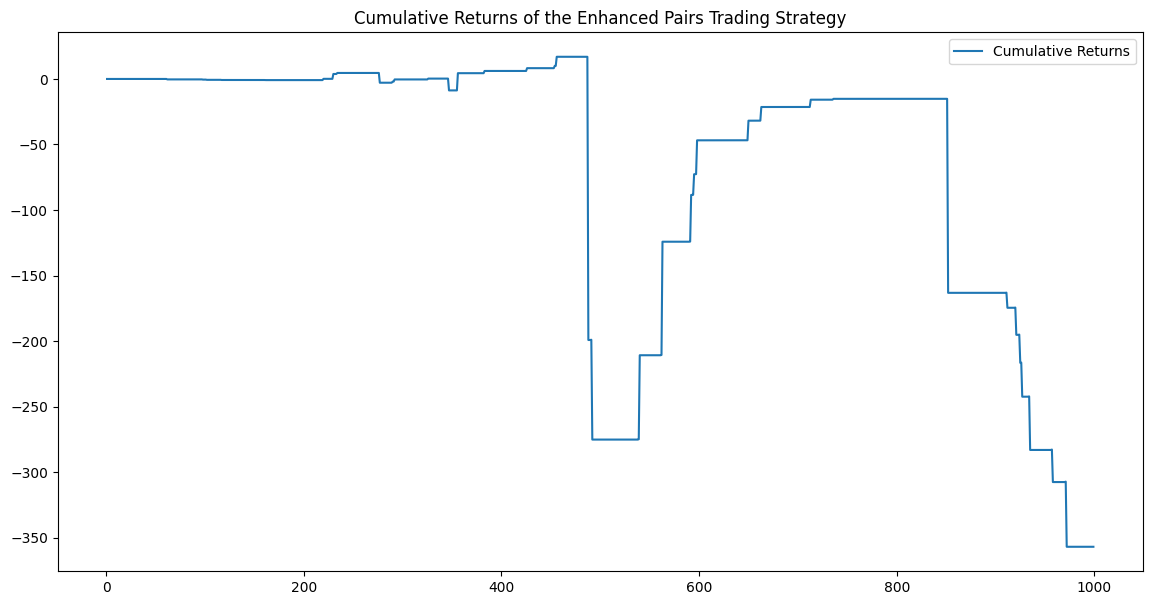

In [14]:
# Plot cumulative returns with transaction costs and stop-loss
plt.figure(figsize=(14, 7))
plt.plot(df['Cumulative Returns'], label='Cumulative Returns')
plt.title('Cumulative Returns of the Enhanced Pairs Trading Strategy')
plt.legend()
plt.show()

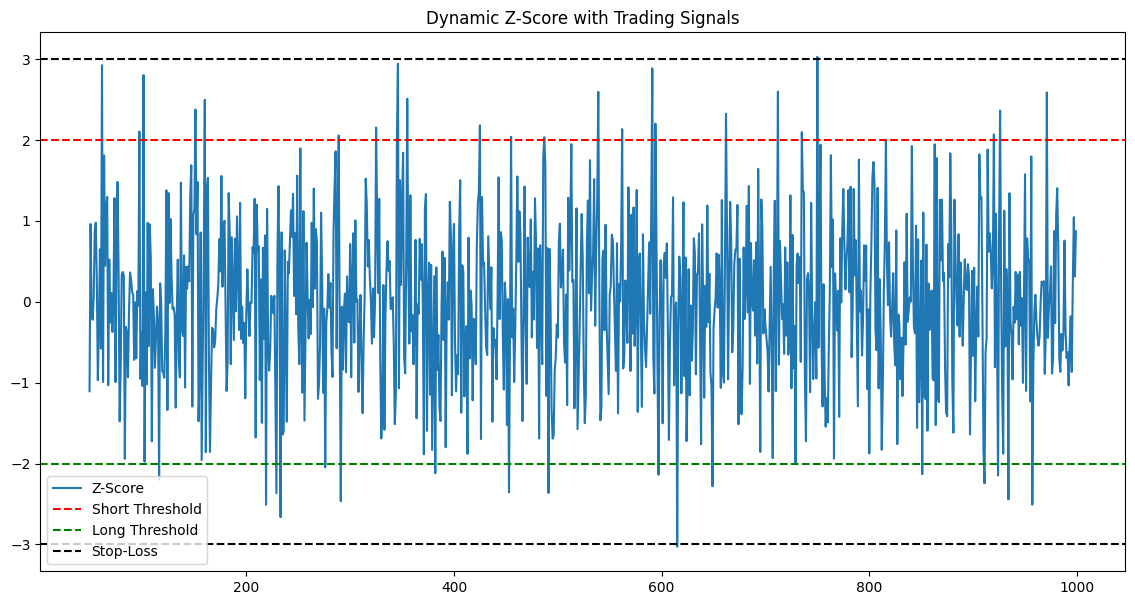

In [15]:
# Plot the dynamic Z-Score and trading signals
plt.figure(figsize=(14, 7))
plt.plot(df['Z-Score'], label='Z-Score')
plt.axhline(upper_threshold, color='red', linestyle='--', label='Short Threshold')
plt.axhline(lower_threshold, color='green', linestyle='--', label='Long Threshold')
plt.axhline(3, color='black', linestyle='--', label='Stop-Loss')
plt.axhline(-3, color='black', linestyle='--')
plt.title('Dynamic Z-Score with Trading Signals')
plt.legend()
plt.show()

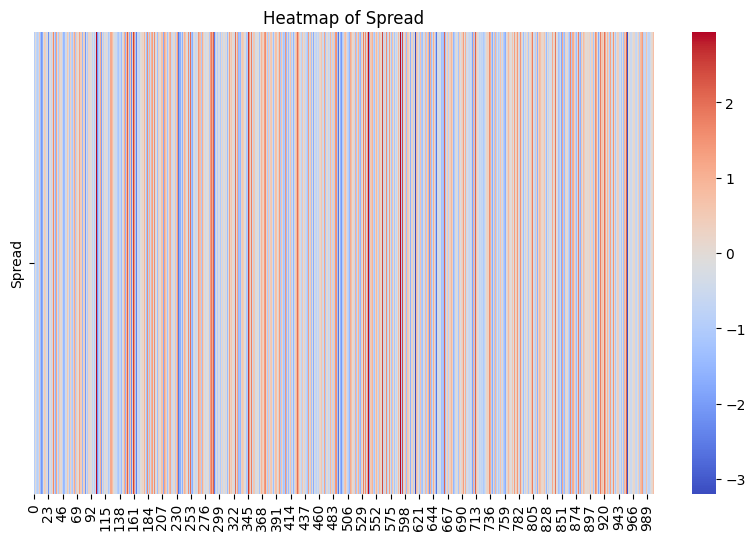

In [16]:
# Heatmap of the spread
plt.figure(figsize=(10, 6))
sns.heatmap(df[['Spread']].T, cmap='coolwarm', cbar=True)
plt.title('Heatmap of Spread')
plt.show()

In [17]:
# Print summary statistics of cumulative returns
print("\nSummary Statistics of Cumulative Returns:")
print(df['Cumulative Returns'].describe())


Summary Statistics of Cumulative Returns:
count    999.000000
mean     -63.207942
std      104.146002
min     -356.878838
25%     -124.160920
50%      -15.171009
75%        0.000000
max       16.917560
Name: Cumulative Returns, dtype: float64
